In [2]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

In [3]:
import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

124.42867314630075

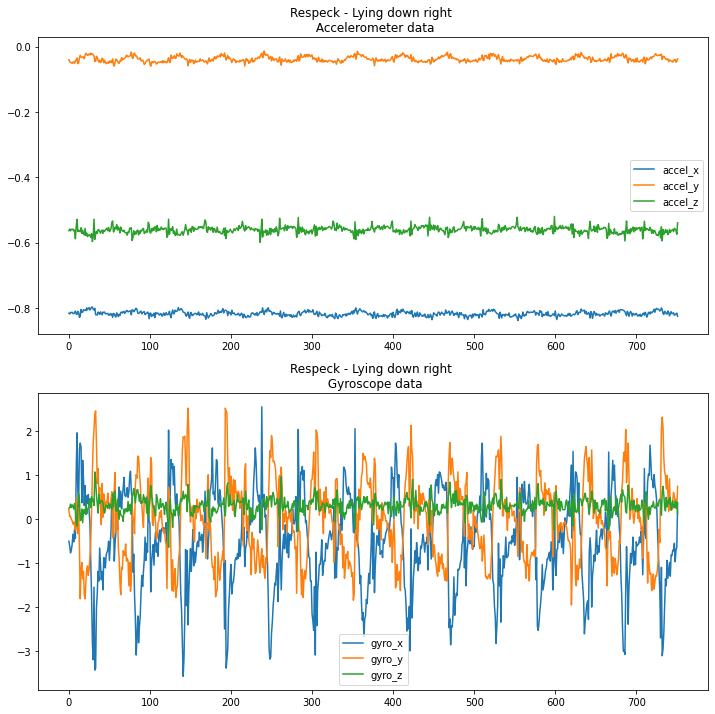

In [4]:
df_respeck = pd.read_csv('Lying_down_on_right.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

66.74242104872462

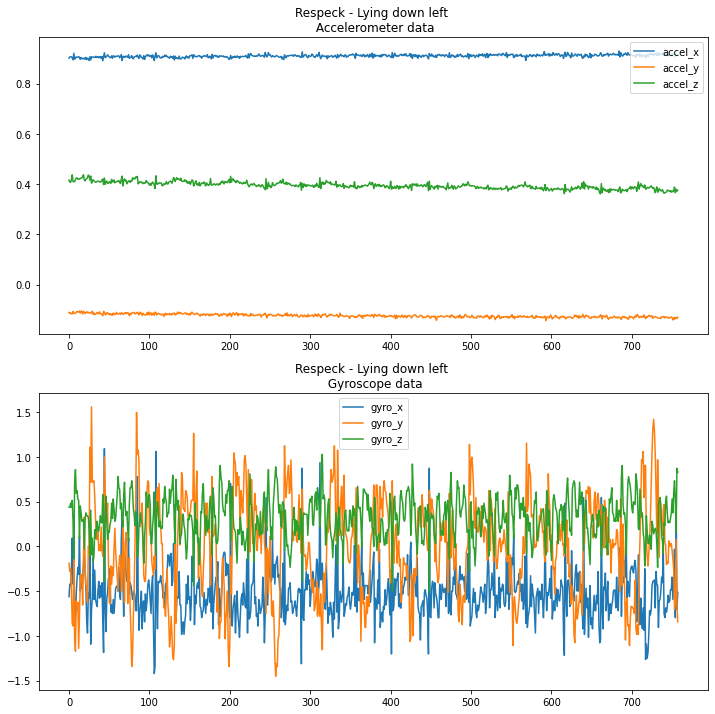

In [5]:
df_respeck = pd.read_csv('Lying_down_on_left.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

153.7102582426303

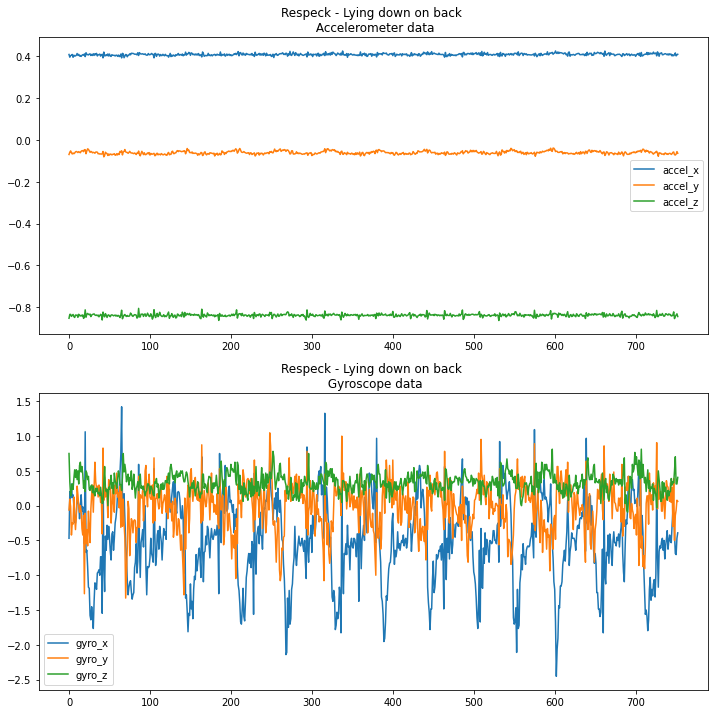

In [6]:
df_respeck = pd.read_csv('Lying_down_on_back.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

21.08904348374478

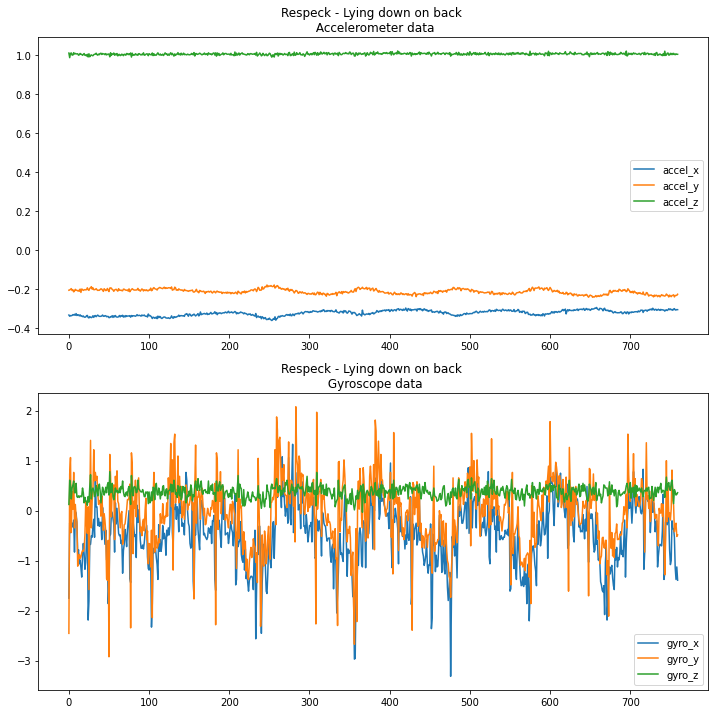

In [7]:
df_respeck = pd.read_csv('Kai_Lying_down_on_back.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

20.372387130517033

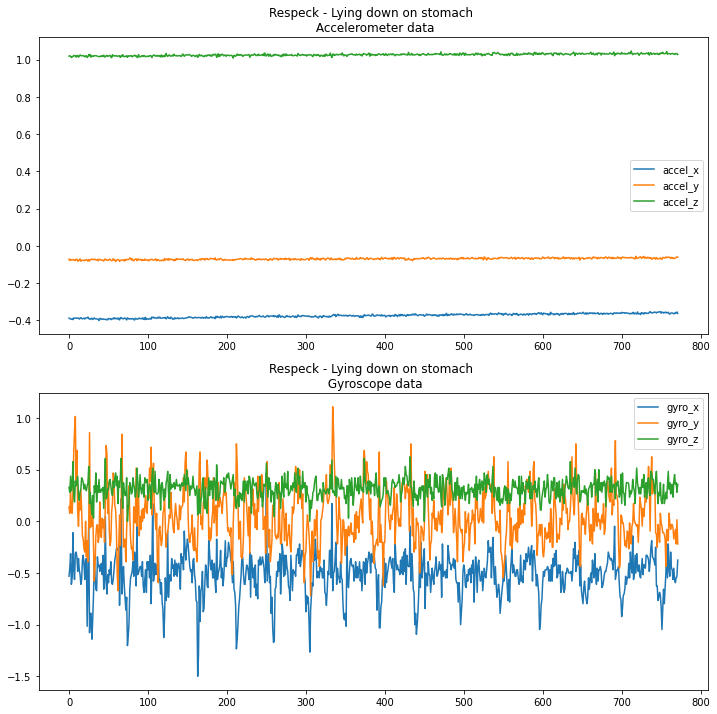

In [8]:
df_respeck = pd.read_csv('Lying_down_on_stomach.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

172.02790653138064

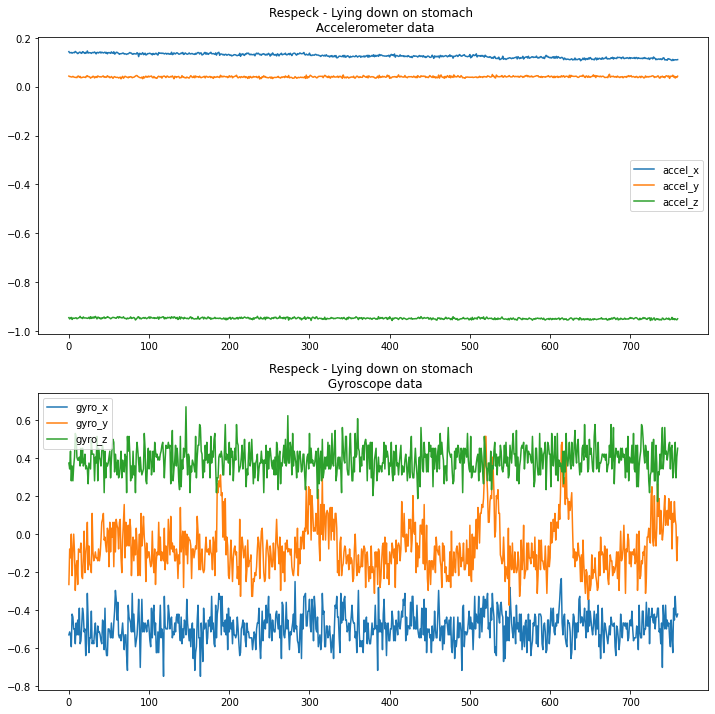

In [9]:
df_respeck = pd.read_csv('Kai_Lying_down_on_stomach.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

69.46420342538426

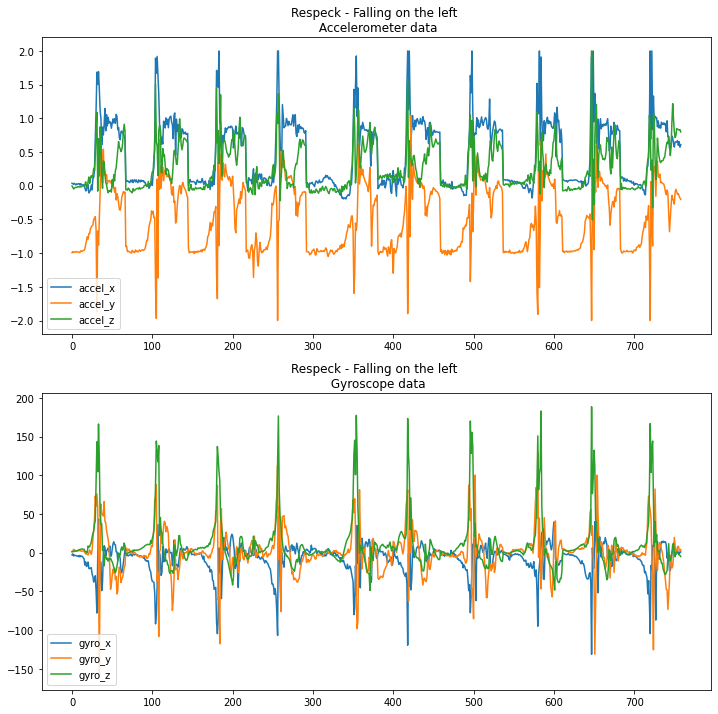

In [10]:
df_respeck = pd.read_csv('Falling_on_the_left.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

110.42553807737214

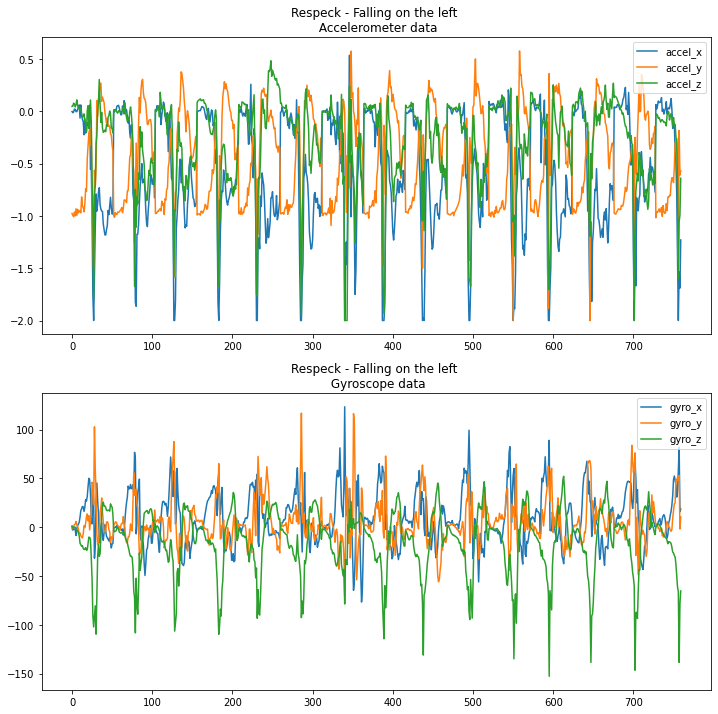

In [11]:
df_respeck = pd.read_csv('Kai_Falling_on_the_left.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

110.31835145200681

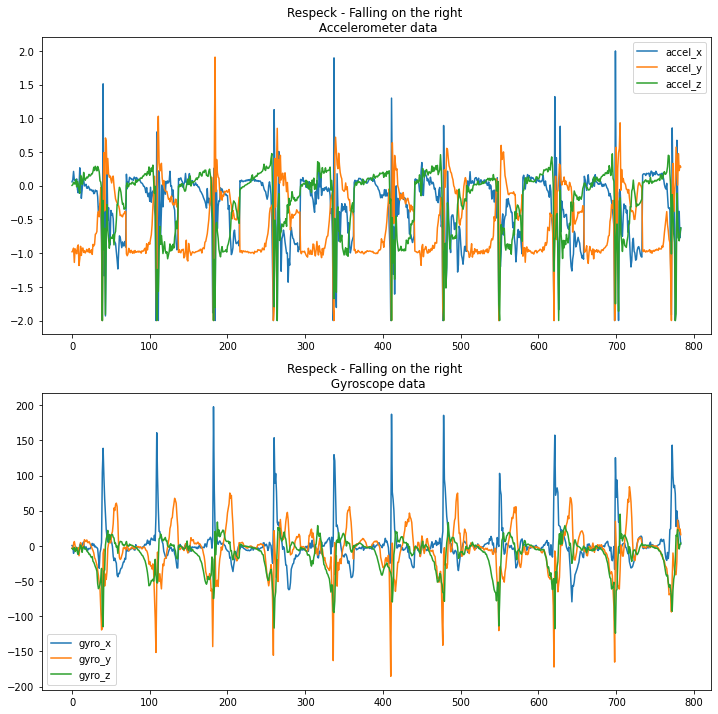

In [12]:
df_respeck = pd.read_csv('Falling_on_the_right.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

52.720822593057285

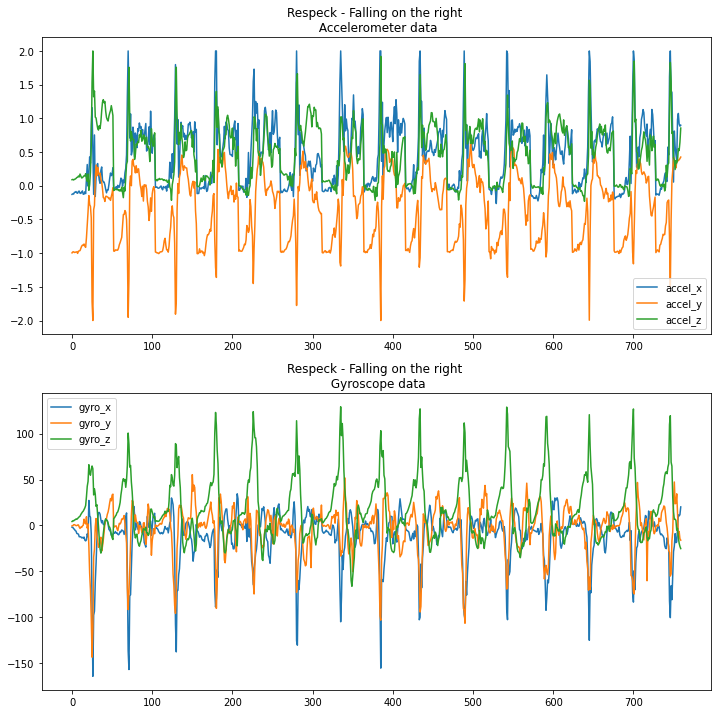

In [13]:
df_respeck = pd.read_csv('Kai_Falling_on_the_right.csv')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z)
theta_z*180/np.pi

In [14]:
base_df = pd.read_csv('Respeck_recordings_clean.csv')
movement_indices = np.asarray(base_df[base_df.activity_type == 'Movement'].index) # drop general movement
base_df.drop(movement_indices, inplace=True)
base_df.reset_index(drop=True, inplace=True)

/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
base_df.activity_type.unique()

array(['Climbing stairs', 'Standing', 'Lying down on stomach',
       'Sitting bent backward', 'Lying down left', 'Lying down on back',
       'Descending stairs', 'Sitting bent forward',
       'Walking at normal speed', 'Running', 'Lying down right',
       'Desk work', 'Sitting', 'Falling on knees', 'Falling on the back',
       'Falling on the right', 'Falling on the left'], dtype=object)

Text(0.5, 1.0, 'Respeck - Lying down right \n Gyroscope data')

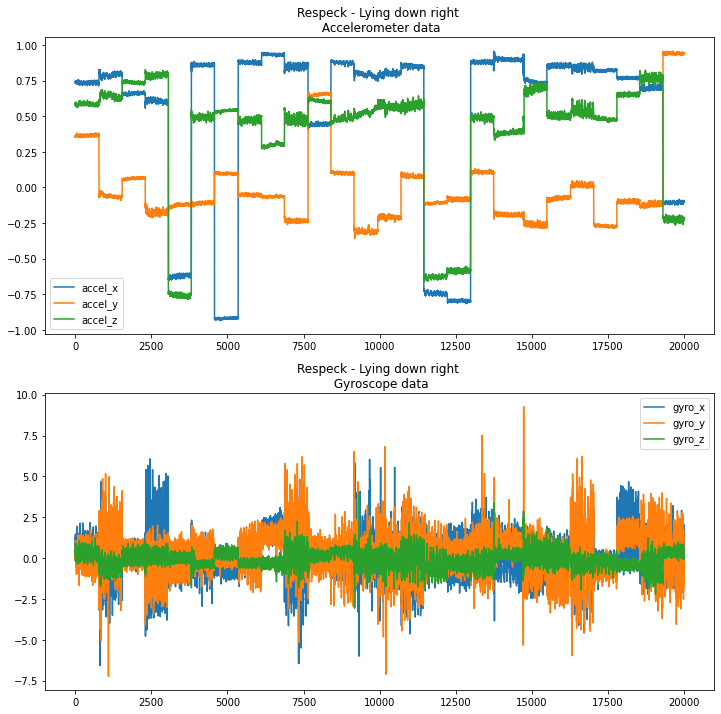

In [16]:
df_respeck = base_df[base_df.activity_type == 'Lying down right'].reset_index(drop=True).head(20000)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

Text(0.5, 1.0, 'Respeck - Lying down left \n Gyroscope data')

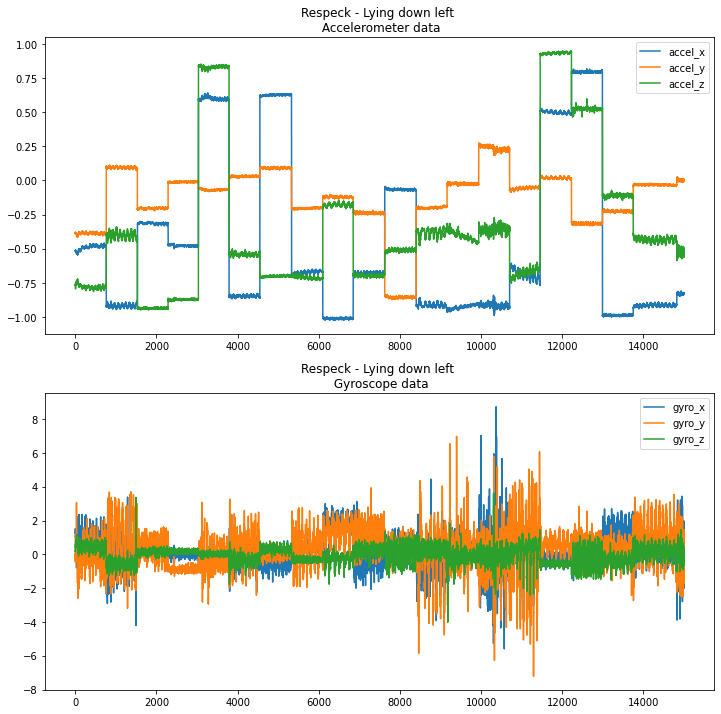

In [17]:
df_respeck = base_df[base_df.activity_type == 'Lying down left'].reset_index(drop=True).head(15000)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

Text(0.5, 1.0, 'Respeck - Lying down on back \n Gyroscope data')

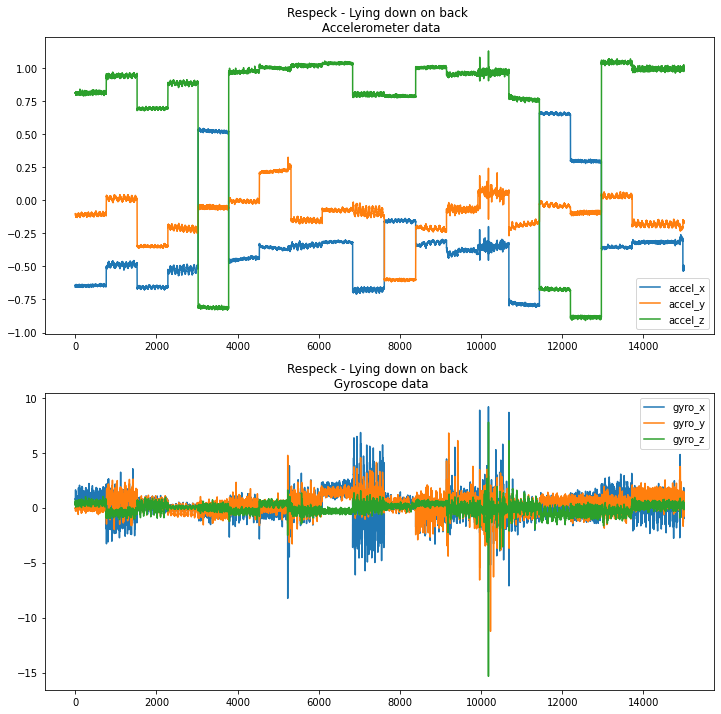

In [18]:
df_respeck = base_df[base_df.activity_type == 'Lying down on back'].reset_index(drop=True).head(15000)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

Text(0.5, 1.0, 'Respeck - Lying down on stomach \n Gyroscope data')

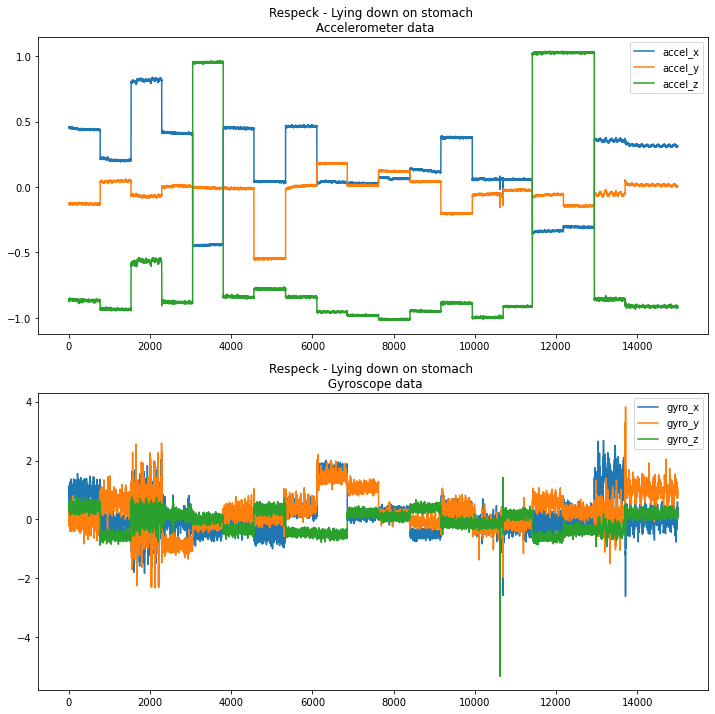

In [19]:
df_respeck = base_df[base_df.activity_type == 'Lying down on stomach'].reset_index(drop=True).head(15000)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

Text(0.5, 1.0, 'Respeck - Standing \n Gyroscope data')

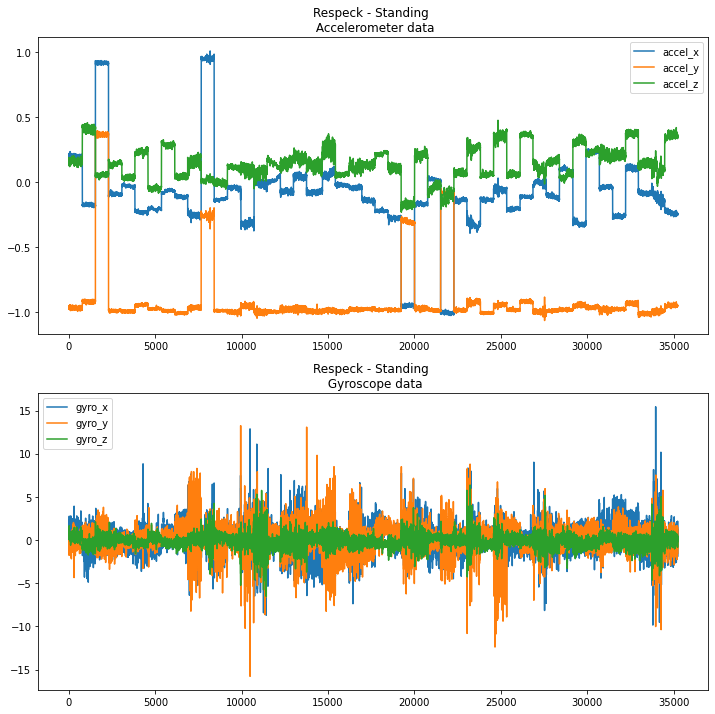

In [22]:
df_respeck = base_df[base_df.activity_type == 'Standing'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

In [251]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [252]:
falling_dfs = []
for _ in range(10):
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on knees'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the right'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the left'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the back'])

falling_df = pd.concat(falling_dfs).reset_index(drop=True)

running_dfs = []
for _ in range(2):
    running_dfs.append(base_df[base_df.activity_type == 'Running'])

running_df = pd.concat(running_dfs).reset_index(drop=True)

In [253]:
base_df = pd.concat([base_df, falling_df, running_df]).reset_index(drop=True)

In [255]:
nan_indices = set()
for i in range(len(base_df)):
    for col in columns_of_interest:
        if pd.isnull(base_df.loc[i, col]):
            nan_indices.add(i)

In [256]:
base_df.drop(list(nan_indices), inplace=True)

In [257]:
subject_dataframes = []

In [258]:
for rid, group in base_df.groupby("subject_id"):
    subject_dataframes.append(group)

In [259]:
n = len(subject_dataframes)
n

46

In [260]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
    # print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    if len(overlapping_windows) == 0:
            continue
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [261]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [262]:
final_sliding_windows.columns

Index(['timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y',
       'gyro_z', 'sensor_type', 'activity_type', 'activity_code', 'subject_id',
       'notes', 'recording_id', 'window_id'],
      dtype='object')

In [263]:
subject_ids = list(set(base_df['subject_id']))

In [264]:
training_partitions = [final_sliding_windows[final_sliding_windows.subject_id != s] for s in subject_ids]

In [265]:
testing_partitions = [final_sliding_windows[final_sliding_windows.subject_id == s] for s in subject_ids]

In [266]:
print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")

The data was collected using the sensors: ['Respeck']
The data was collected for the activities: ['Climbing stairs' 'Standing' 'Lying down on stomach'
 'Sitting bent backward' 'Lying down left' 'Lying down on back'
 'Descending stairs' 'Sitting bent forward' 'Walking at normal speed'
 'Running' 'Lying down right' 'Desk work' 'Sitting' 'Falling on knees'
 'Falling on the back' 'Falling on the right' 'Falling on the left']
The number of unique recordings is: 830
The subject IDs in the recordings are: 46


In [267]:
reduced_class_labels = {
    'Falling on the left':0,
    'Falling on knees':0,
    'Falling on the back':0,
    'Descending stairs':3,
    'Standing':1,
    'Lying down right':2,
    'Walking at normal speed':3,
    'Lying down on back':2,
    'Desk work':1,
    'Running':3,
    'Climbing stairs':3,
    'Falling on the right':0,
    'Sitting bent backward':1,
    'Sitting bent forward':1,
    'Lying down left':2,
    'Lying down on stomach':2,
    'Sitting':1
}

In [268]:
class_labels = {
    'Falling on the left':0,
    'Falling on knees':1,
    'Falling on the back':2,
    'Descending stairs':3,
    'Standing':4,
    'Lying down right':5,
    'Walking at normal speed':6,
    'Lying down on back':7,
    'Desk work':8,
    'Running':9,
    'Climbing stairs':10,
    'Falling on the right':11,
    'Sitting bent backward':12,
    'Sitting bent forward':13,
    'Lying down left':14,
    'Lying down on stomach':16,
    'Sitting':17
}

In [269]:
falling_class_labels = {
    0:0,
    11:1,
    2:2,
    1:3
}

falling_class_labels_inv = {
    0:0,
    1:11,
    2:2,
    3:1
}

In [270]:
sitting_standing_class_labels = {
    13:0,
    4:1,
    17:2,
    8:3,
    12:4
}

sitting_standing_class_labels_inv = {
    0:13,
    1:4,
    2:17,
    3:8,
    4:12
}

In [271]:
lying_class_labels = {
    16:0,
    7:1,
    14:2,
    5:3
}

lying_class_labels_inv = {
    0:16,
    1:7,
    2:14,
    3:5
}

In [272]:
moving_class_labels = {
    10:0,
    3:1,
    6:2,
    9:3
}

moving_class_labels_inv = {
    0:10,
    1:3,
    2:6,
    3:9
}

In [273]:
len(final_sliding_windows)

1207650

In [274]:
n

46

In [275]:
# randomly select five partitions and train the model on them
random_partitions = [4, 17, 26, 31, 40]

In [276]:
# get the training and testing features
feature_lists_train = []
feature_lists_test = []

In [277]:
for i in random_partitions:
    print(i)
    # now extract all features
    feature_list = []

    for col in columns_of_interest:
        new_features = tsfresh.extract_features(timeseries_container=training_partitions[i], column_id='window_id',
                            column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters(), n_jobs=8)
        feature_list.append(new_features)

    feature_list = pd.concat(feature_list, axis=1)
    
    feature_lists_train.append(feature_list)

4


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


17


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.54it/s]


26


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.15it/s]


31


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.55it/s]


40


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


In [278]:
for i in random_partitions:
    print(i)
    # now extract all features
    feature_list = []

    for col in columns_of_interest:
        new_features = tsfresh.extract_features(timeseries_container=testing_partitions[i], column_id='window_id',
                            column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters(), n_jobs=8)
        feature_list.append(new_features)

    feature_list = pd.concat(feature_list, axis=1)
    
    feature_lists_test.append(feature_list)

4


Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 191.55it/s]


17


Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 178.96it/s]


26


Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 195.04it/s]


31


Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 187.30it/s]


40


Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 183.56it/s]


In [279]:
accuracy_scores = []

rfc = RandomForestClassifier()

for i in range(len(random_partitions)):
    print(i, end=' ')
    X_train = feature_lists_train[i].to_numpy()
    X_test = feature_lists_test[i].to_numpy()
    y_train = training_partitions[random_partitions[i]].groupby("window_id")[['activity_type']].agg(np.min).replace(reduced_class_labels).to_numpy()
    y_test = testing_partitions[random_partitions[i]].groupby("window_id")[['activity_type']].agg(np.min).replace(reduced_class_labels).to_numpy()
    rfc.fit(X_train, y_train.ravel())
    y_pred_labels = rfc.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred_labels))

0 1 2 3 4 

In [280]:
[100*x for x in accuracy_scores]

[100.0, 100.0, 100.0, 100.0, 92.34828496042216]

In [281]:
sum(accuracy_scores)/len(accuracy_scores)

0.9846965699208443

In [33]:
rfc = RandomForestClassifier()

# working with the 2nd partition
X_train = feature_lists_train[2].to_numpy()
X_test = feature_lists_test[2].to_numpy()

y_train = training_partitions[random_partitions[2]].groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels).to_numpy()
y_test = testing_partitions[random_partitions[2]].groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels).to_numpy()

y_train_reduced = training_partitions[random_partitions[2]].groupby("window_id")[['activity_type']].agg(np.min).replace(reduced_class_labels).to_numpy()
y_test_reduced = testing_partitions[random_partitions[2]].groupby("window_id")[['activity_type']].agg(np.min).replace(reduced_class_labels).to_numpy()

rfc.fit(X_train, y_train_reduced.ravel())
y_pred_labels = rfc.predict(X_test)

accuracy_score(y_test_reduced, y_pred_labels)

0.888631090487239

In [35]:
# get the class-specific datasets and labels for trainings

falling_indices = [j for j in range(len(y_train)) if (y_train[j]==0 or y_train[j]==1 or y_train[j]==2 or y_train[j]==11)]
X_train_falling  = np.asarray([X_train[j] for j in falling_indices])
y_train_falling = np.asarray([y_train[j] for j in falling_indices])

sitting_standing_indices = [j for j in range(len(y_train)) if (y_train[j]==4 or y_train[j]==8 or y_train[j]==12 or y_train[j]==13 or y_train[j]==17)]
X_train_sitting_standing = np.asarray([X_train[j] for j in sitting_standing_indices])
y_train_sitting_standing = np.asarray([y_train[j] for j in sitting_standing_indices])

lying_indices = [j for j in range(len(y_train)) if (y_train[j]==5 or y_train[j]==7 or y_train[j]==14 or y_train[j]==16)]
X_train_lying = np.asarray([X_train[j] for j in lying_indices])
y_train_lying = np.asarray([y_train[j] for j in lying_indices])

moving_indices = [j for j in range(len(y_train)) if (y_train[j]==3 or y_train[j]==6 or y_train[j]==9 or y_train[j]==10 or y_train[j]==15)]
X_train_moving = np.asarray([X_train[j] for j in moving_indices])
y_train_moving = np.asarray([y_train[j] for j in moving_indices])


In [ ]:
# set up and train the class-specific models

rfc_falling = RandomForestClassifier()
rfc_falling.fit(X_train_falling, y_train_falling)

rfc_sitting_standing = RandomForestClassifier()
rfc_sitting_standing.predict(X_train_sitting_standing, y_train_sitting_standing)

rfc_lying = RandomForestClassifier()
rfc_lying.predict(X_train_lying, y_train_lying)

rfc_moving = RandomForestClassifier()
rfc_moving.predict(X_train_moving, y_train_moving)

In [34]:
# to be used in predicting the class-specific labels

pred_falling_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==0)]
X_pred_falling = np.array([X_test[j] for j in pred_falling_indices])

pred_sitting_standing_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==1)]
X_pred_sitting_standing = np.array([X_test[j] for j in pred_sitting_standing_indices])

pred_lying_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==2)]
X_pred_lying = np.array([X_test[j] for j in pred_lying_indices])

pred_moving_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==3)]
X_pred_moving = np.array([X_test[j] for j in pred_moving_indices])

In [93]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D

In [315]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 4
window_size

50

In [316]:
# An LSTM model
'''
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
'''

"\nmodel = Sequential()\nmodel.add(LSTM(100, input_shape=(window_size, n_features)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nmodel.summary()\n"

In [317]:
# the CNN model
'''
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.SGD(lr=0.01, momentum=0.5),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

model.summary()
'''

"\nmodel = Sequential()\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', \n                 input_shape=(window_size, n_features)))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Flatten())\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\n\nmodel.compile(\n    optimizer=optimizers.SGD(lr=0.01, momentum=0.5),\n    loss='categorical_crossentropy',\n    metrics = ['accuracy'])\n\nmodel.summary()\n"

In [318]:
X_train = []
y_train = []
y_train_reduced = []

for window_id, group in training_partitions[26].groupby('window_id'):
    # print(f"window_id = {window_id}")
    shape = group[columns_of_interest].values.shape
    # print(f"shape = {shape}")    
    X_train.append(group[columns_of_interest].values)
    y_train.append(class_labels[group["activity_type"].values[0]])
    y_train_reduced.append(reduced_class_labels[group["activity_type"].values[0]])
    
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
y_train_reduced = np.asarray(y_train_reduced)

print(f"X train shape = {X_train.shape}")
print(f"y train shape = {y_train.shape}")

X train shape = (23773, 50, 6)
y train shape = (23773,)


In [319]:
falling_indices = [j for j in range(len(y_train)) if (y_train[j]==0 or y_train[j]==1 or y_train[j]==2 or y_train[j]==11)]
X_train_falling  = np.asarray([X_train[j] for j in falling_indices])
y_train_falling = np.asarray([y_train[j] for j in falling_indices])


In [320]:
sitting_standing_indices = [j for j in range(len(y_train)) if (y_train[j]==4 or y_train[j]==8 or y_train[j]==12 or y_train[j]==13 or y_train[j]==17)]
X_train_sitting_standing = np.asarray([X_train[j] for j in sitting_standing_indices])
y_train_sitting_standing = np.asarray([y_train[j] for j in sitting_standing_indices])


In [321]:
lying_indices = [j for j in range(len(y_train)) if (y_train[j]==5 or y_train[j]==7 or y_train[j]==14 or y_train[j]==16)]
X_train_lying = np.asarray([X_train[j] for j in lying_indices])
y_train_lying = np.asarray([y_train[j] for j in lying_indices])


In [322]:
moving_indices = [j for j in range(len(y_train)) if (y_train[j]==3 or y_train[j]==6 or y_train[j]==9 or y_train[j]==10 or y_train[j]==15)]
X_train_moving = np.asarray([X_train[j] for j in moving_indices])
y_train_moving = np.asarray([y_train[j] for j in moving_indices])


In [323]:
print(len(falling_indices))
print(len(sitting_standing_indices))
print(len(lying_indices))
print(len(moving_indices))

4361
6567
5296
7549


In [324]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17}

In [325]:
y_train_falling = np.asarray([falling_class_labels[y_train_falling[j]] for j in range(len(y_train_falling))])

y_train_sitting_standing = np.asarray([sitting_standing_class_labels[y_train_sitting_standing[j]] for j in range(len(y_train_sitting_standing))])

y_train_lying = np.asarray([lying_class_labels[y_train_lying[j]] for j in range(len(y_train_lying))])

y_train_moving = np.asarray([moving_class_labels[y_train_moving[j]] for j in range(len(y_train_moving))])

In [326]:
X_test = []
y_test = []
y_test_reduced = []


for window_id, group in testing_partitions[26].groupby('window_id'):
    # print(f"window_id = {window_id}")
    shape = group[columns_of_interest].values.shape
    # print(f"shape = {shape}")    
    X_test.append(group[columns_of_interest].values)
    y_test.append(class_labels[group["activity_type"].values[0]])
    y_test_reduced.append(reduced_class_labels[group["activity_type"].values[0]])

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_reduced = np.array(y_test_reduced)

print(f"X test shape = {X_test.shape}")
print(f"y test shape = {y_test.shape}")

X test shape = (380, 50, 6)
y test shape = (380,)


In [327]:
'''
n_steps, n_length = 2, 25
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

# A CNN-LSTM model

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, input_shape=(window_size, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
'''

"\nn_steps, n_length = 2, 25\nX_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))\nX_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))\n\n# A CNN-LSTM model\n\nmodel = Sequential()\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))\nmodel.add(TimeDistributed(Dropout(0.5)))\nmodel.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel.add(TimeDistributed(Flatten()))\nmodel.add(LSTM(100, input_shape=(window_size, n_features)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nmodel.summary()\n"

In [328]:
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 2, 25
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

# the ConvLSTM Network Model for the top hierarchy

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, 1, 23, 64)         54016     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 23, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1472)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               147300    
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 404       
Total params: 201,720
Trainable params: 201,720
Non-trainable params: 0
_________________________________________________________________


In [329]:
n_classes

4

In [330]:
def OHE(num, n_classes):
    return ([0 for x in range(num)] + [1] + [0 for x in range(n_classes - num - 1)])

In [331]:
def get_OHE(l, n_classes):
    return ([OHE(x, n_classes) for x in l])

In [332]:
y_train_reduced = get_OHE(y_train_reduced, n_classes)

In [333]:
y_train_reduced = np.asarray(y_train_reduced, dtype=float)

In [334]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train_reduced.shape}")

X_train shape = (23773, 2, 1, 25, 6)
y_train shape = (23773, 4)


In [335]:
# fit network
model.fit(X_train, y_train_reduced, epochs=5, batch_size=64)

Epoch 1/5
372/372 [==============================] - 15s 28ms/step - loss: 0.7499 - accuracy: 0.7383
Epoch 2/5
372/372 [==============================] - 11s 28ms/step - loss: 0.1187 - accuracy: 0.9566
Epoch 3/5
372/372 [==============================] - 11s 30ms/step - loss: 0.0933 - accuracy: 0.9678
Epoch 4/5
372/372 [==============================] - 11s 29ms/step - loss: 0.0825 - accuracy: 0.9712
Epoch 5/5
372/372 [==============================] - 11s 30ms/step - loss: 0.0754 - accuracy: 0.9749


In [336]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_pred_labels.shape

(380,)

In [337]:
accuracy = accuracy_score(y_test_reduced, y_pred_labels)
accuracy

1.0

In [338]:
X_train_fallings = [X_train_falling for _ in range(5)]
X_train_falling_concat = np.concatenate(X_train_fallings)
y_train_fallings = [y_train_falling for _ in range(5)]
y_train_falling_concat = np.concatenate(y_train_fallings)

X_train_sitting_standings = [X_train_sitting_standing for _ in range(5)]
X_train_sitting_standing_concat = np.concatenate(X_train_sitting_standings)
y_train_sitting_standings = [y_train_sitting_standing for _ in range(5)]
y_train_sitting_standing_concat = np.concatenate(y_train_sitting_standings)

X_train_lyings = [X_train_lying for _ in range(5)]
X_train_lying_concat = np.concatenate(X_train_lyings)
y_train_lyings = [y_train_lying for _ in range(5)]
y_train_lying_concat = np.concatenate(y_train_lyings)

X_train_movings = [X_train_moving for _ in range(5)]
X_train_moving_concat = np.concatenate(X_train_movings)
y_train_movings = [y_train_moving for _ in range(5)]
y_train_moving_concat = np.concatenate(y_train_movings)

In [339]:
len(X_train_falling_concat)

21805

In [340]:
def setup_falling_model(n_classes=4, X_train_falling=X_train_falling_concat, y_train_falling=y_train_falling_concat):
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 2, 25
    X_train_falling = X_train_falling.reshape((X_train_falling.shape[0], n_steps, 1, n_length, n_features))
    
    # the ConvLSTM Network Model for the 'falling' class
    falling_model = Sequential()
    falling_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    falling_model.add(Dropout(0.5))
    falling_model.add(Flatten())
    falling_model.add(Dense(100, activation='relu'))
    falling_model.add(Dense(n_classes, activation='softmax'))
    falling_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_train_falling = np.asarray(get_OHE(y_train_falling, n_classes), dtype=np.float32)
    
    falling_model.fit(X_train_falling, y_train_falling, epochs=5, batch_size=64)
    return falling_model

In [341]:
falling_model = setup_falling_model()

Epoch 1/5
341/341 [==============================] - 14s 30ms/step - loss: 0.7939 - accuracy: 0.8275
Epoch 2/5
341/341 [==============================] - 10s 30ms/step - loss: 0.0075 - accuracy: 0.9977
Epoch 3/5
341/341 [==============================] - 10s 30ms/step - loss: 0.0031 - accuracy: 0.9989
Epoch 4/5
341/341 [==============================] - 10s 30ms/step - loss: 0.0053 - accuracy: 0.9987
Epoch 5/5
341/341 [==============================] - 10s 29ms/step - loss: 0.0019 - accuracy: 0.9995


In [342]:
def setup_sitting_standing_model(n_classes=5, X_train_sitting_standing=X_train_sitting_standing_concat, y_train_sitting_standing=y_train_sitting_standing_concat):
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 2, 25
    X_train_sitting_standing = X_train_sitting_standing.reshape((X_train_sitting_standing.shape[0], n_steps, 1, n_length, n_features))
    
    # the ConvLSTM Network Model for the 'sitting_standing' class
    sitting_standing_model = Sequential()
    sitting_standing_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    sitting_standing_model.add(Dropout(0.5))
    sitting_standing_model.add(Flatten())
    sitting_standing_model.add(Dense(100, activation='relu'))
    sitting_standing_model.add(Dense(n_classes, activation='softmax'))
    sitting_standing_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_train_sitting_standing = np.asarray(get_OHE(y_train_sitting_standing, n_classes), dtype=np.float32)
    
    sitting_standing_model.fit(X_train_sitting_standing, y_train_sitting_standing, epochs=5, batch_size=64)
    return sitting_standing_model

In [343]:
sitting_standing_model = setup_sitting_standing_model()

Epoch 1/5
514/514 [==============================] - 19s 31ms/step - loss: 1.0167 - accuracy: 0.5805
Epoch 2/5
514/514 [==============================] - 15s 30ms/step - loss: 0.5666 - accuracy: 0.7624
Epoch 3/5
514/514 [==============================] - 16s 30ms/step - loss: 0.4188 - accuracy: 0.8287
Epoch 4/5
514/514 [==============================] - 15s 30ms/step - loss: 0.3189 - accuracy: 0.8764
Epoch 5/5
514/514 [==============================] - 16s 31ms/step - loss: 0.2199 - accuracy: 0.9162


In [345]:
def setup_moving_model(n_classes=5, X_train_moving=X_train_moving_concat, y_train_moving=y_train_movings_concat):
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 2, 25
    X_train_moving = X_train_moving.reshape((X_train_moving.shape[0], n_steps, 1, n_length, n_features))
    
    # the ConvLSTM Network Model for the 'moving' class
    moving_model = Sequential()
    moving_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    moving_model.add(Dropout(0.5))
    moving_model.add(Flatten())
    moving_model.add(Dense(100, activation='relu'))
    moving_model.add(Dense(n_classes, activation='softmax'))
    moving_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_train_moving = np.asarray(get_OHE(y_train_moving, n_classes), dtype=np.float32)
    
    moving_model.fit(X_train_moving, y_train_moving, epochs=5, batch_size=64)
    return moving_model

In [346]:
setup_moving_model = setup_moving_model()

Epoch 1/5
590/590 [==============================] - 23s 33ms/step - loss: 0.7742 - accuracy: 0.7029
Epoch 2/5
590/590 [==============================] - 19s 31ms/step - loss: 0.2296 - accuracy: 0.9066
Epoch 3/5
590/590 [==============================] - 17s 29ms/step - loss: 0.1256 - accuracy: 0.9503
Epoch 4/5
590/590 [==============================] - 18s 31ms/step - loss: 0.0992 - accuracy: 0.9659
Epoch 5/5
590/590 [==============================] - 17s 29ms/step - loss: 0.0641 - accuracy: 0.9782


In [347]:
def setup_lying_model(n_classes=4, X_train_lying=X_train_lying_concat, y_train_lying=y_train_lying_concat):
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 2, 25
    X_train_lying = X_train_lying.reshape((X_train_lying.shape[0], n_steps, 1, n_length, n_features))
    
    # the ConvLSTM Network Model for the 'lying' class
    lying_model = Sequential()
    lying_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    lying_model.add(Dropout(0.5))
    lying_model.add(Flatten())
    lying_model.add(Dense(100, activation='relu'))
    lying_model.add(Dense(n_classes, activation='softmax'))
    lying_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_train_lying = np.asarray(get_OHE(y_train_lying, n_classes), dtype=np.float32)
    
    lying_model.fit(X_train_lying, y_train_lying, epochs=5, batch_size=64)
    return lying_model

In [348]:
lying_model = setup_lying_model()

Epoch 1/5
414/414 [==============================] - 15s 29ms/step - loss: 0.3856 - accuracy: 0.8881
Epoch 2/5
414/414 [==============================] - 12s 29ms/step - loss: 0.0345 - accuracy: 0.9914
Epoch 3/5
414/414 [==============================] - 12s 29ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 4/5
414/414 [==============================] - 13s 31ms/step - loss: 0.0069 - accuracy: 0.9982
Epoch 5/5
414/414 [==============================] - 13s 32ms/step - loss: 0.0095 - accuracy: 0.9967


In [229]:
# y_tests = [np.asarray([j for j in range(len(y_test)) if y_test[j]==0], dtype=int)] + [np.argwhere(y_test==i).ravel() for i in range(1,4)]

In [349]:
pred_falling_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==0)]
pred_sitting_standing_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==1)]
pred_lying_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==2)]
pred_moving_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==3)]

print(pred_moving_indices)

[145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379]


In [350]:
X_pred_falling = np.array([X_test[j] for j in pred_falling_indices])
X_pred_falling.shape

(0,)

In [351]:
X_pred_sitting_standing = np.array([X_test[j] for j in pred_sitting_standing_indices])
X_pred_sitting_standing.shape

(145, 2, 1, 25, 6)

In [352]:
X_pred_lying = np.array([X_test[j] for j in pred_lying_indices])
X_pred_lying.shape

(116, 2, 1, 25, 6)

In [353]:
X_pred_moving = np.array([X_test[j] for j in pred_moving_indices])
X_pred_moving.shape

(119, 2, 1, 25, 6)

In [354]:
# reconstruct the original labels
y_pred_orig_labels = np.zeros(shape=(len(y_pred_labels),), dtype=int)

In [355]:
if len(X_pred_falling != 0):
    y_pred_falling_ohe = falling_model.predict(X_pred_falling)
    y_pred_falling_labels = np.argmax(y_pred_falling_ohe, axis=1)
    # convert labels back to original
    y_pred_falling_orig_labels = [falling_class_labels_inv[y_pred_falling_labels[j]] for j in range(len(y_pred_falling_labels))]
    # print(np.asarray(y_pred_falling_orig_labels))
    for j in range(len(y_pred_falling_labels)):
        y_pred_orig_labels[pred_falling_indices[j]] = y_pred_falling_orig_labels[j]

In [356]:
if len(X_pred_sitting_standing != 0):    
    y_pred_sitting_standing_ohe = falling_model.predict(X_pred_sitting_standing)
    y_pred_sitting_standing_labels = np.argmax(y_pred_sitting_standing_ohe, axis=1)
    # convert labels back to original
    y_pred_sitting_standing_orig_labels = [sitting_standing_class_labels_inv[y_pred_sitting_standing_labels[j]] for j in range(len(y_pred_sitting_standing_labels))]
    # print(np.asarray(y_pred_sitting_standing_orig_labels))
    for j in range(len(y_pred_sitting_standing_labels)):
        y_pred_orig_labels[pred_sitting_standing_indices[j]] = y_pred_sitting_standing_orig_labels[j]

In [357]:
if len(X_pred_lying != 0):    
    y_pred_lying_ohe = falling_model.predict(X_pred_lying)
    y_pred_lying_labels = np.argmax(y_pred_lying_ohe, axis=1)
    # convert labels back to original
    y_pred_lying_orig_labels = [lying_class_labels_inv[y_pred_lying_labels[j]] for j in range(len(y_pred_lying_labels))]
    # print(np.asarray(y_pred_lying_orig_labels))
    for j in range(len(y_pred_lying_labels)):
        y_pred_orig_labels[pred_lying_indices[j]] = y_pred_lying_orig_labels[j]

In [358]:
if len(X_pred_moving != 0):    
    y_pred_moving_ohe = falling_model.predict(X_pred_moving)
    y_pred_moving_labels = np.argmax(y_pred_moving_ohe, axis=1)
    # convert labels back to original
    y_pred_moving_orig_labels = [moving_class_labels_inv[y_pred_moving_labels[j]] for j in range(len(y_pred_moving_labels))]
    # print(np.asarray(y_pred_moving_orig_labels))
    for j in range(len(y_pred_moving_labels)):
        y_pred_orig_labels[pred_moving_indices[j]] = y_pred_moving_orig_labels[j]

In [359]:
y_pred_orig_labels    

array([17, 17,  8,  4,  4, 13, 17, 17, 17, 17, 17, 13,  8,  8,  8, 17, 13,
       13, 17, 17,  4, 17, 17, 17, 17, 17, 17, 17,  8,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16,  6, 10,  3,  3,  3,  6, 10,  3,
        6, 10, 10,  3,  3,  3, 10,  3,  3, 10, 10,  3,  3,  3,  3,  6,  3,
        3,  3,  3,  3,  3,  6,  3,  3, 10,  3,  3,  3, 10,  3,  3,  6,  3,
        6,  3,  3, 10, 10, 10,  3,  3,  6, 10,  3,  3,  6, 10,  3,  3,  3,
        3,  3,  3,  6,  3,  3,  3,  6,  6,  6,  6, 10,  3,  3,  3,  6,  3,
        3,  3, 10,  6,  3

In [360]:
y_test

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [137]:
accuracy_score(y_test, y_pred_orig_labels)

0.20689655172413793